# <center>Capstone Project - The Battle of Neighborhoods</center>

<center> <h3> Moving from <span style="color:blue">Ottawa</span> to <span style="color:blue">Toronto?</span> - Determine neighborhoods in Toronto that are similar to your current neighboorhood in Ottawa ...</h3> </center>

## Table of contents:
1. [Introduction (Business Problem)](#intro)
2. [Data](#data)
3. [Methodology & Analysis](#method)
4. [Results and Discussion](#results)
5. [Conclusion](#conclusion)


## Introduction (Business Problem) <a name="intro"></a>

This project is inspired by the challenges I faced with my family when trying to move from **Winnipeg** to **Ottawa**. We particularly had difficulties with selecting a decent neighbourhood in Ottawa which was similar to where we lived in Winnipeg considering different ammenities such as schools for our kids, parks, bars, restaurants etc. 

I decided to move things around a bit with this project, considering the recent increasing migration between **Ottawa** and **Toronto** *(the top 2 cities in Ontario, Canada based on population and metropolitan nature)*, I figured there'd be several families like mine but this time leaving Ottawa and in similar situation of deciding which neighborhood to settle in Toronto - *these are my stakeholders and I intend to help them solve this problem*.

This project aims to determine clusters of neighborhood in Ottawa and compare them with clusters of neighborhoods in Toronto. Afterwards, determine neighbourhoods of Ottawa that are in similar clusters as Toronto neighborhoods. In addition to this, we will consider proximity to Downtown Toronto i.e. candidate neighborhoods will further be ranked by proximity to Downtown Toronto before suggestions and conclusions are made.


## Data <a name="data"></a>

To achieve our objective, we would require neighborhood data (with longitude & latitude coordinates) for both Ottawa and Ontario. After searching extensively on the internet, it is obvious that this data (especially in our required format) is not readilly available so we have to find alternative ways to acquire the data. The adopted approach will be to **scrape** the list of Ottawa and Toronto neighborhoods from Wikipedia, we will then wrangle the data to transform it into a format that makes it useful to acquire longitude & latitude information of each neighborhood using **geopy geocoder library**.

We will then identify the coordinates of Downtown Toronto and compute the distance of all Toronto neighborhoods from the Downtown center. We will proceed to use the **Foursquare location data** to determine top venues across all neighborhoods in the 2 cities (Ottawa and Toronto).

The data will be properly analysed and transformed to get it ready for further modelling.

## Methodology & Analysis <a name="method"></a>

The approach will be to get all the neighborhoods in Ottawa and Toronto in the following format: \["Neighborhood","City","Latitude","Longitude"\]. we will combine the data from the 2 cities into one dataframe and run clustering analysis using KMeans algorithm to determine the clusters of neighborhoods in these cities. We will determine the optimal value of K using the elbow method. After clusters have been created, we will examine the output and make our conclusions and recommendations.

Let's get started with data wrangling and analysis

<h5> First we will install relevant libraries </h5>

In [3]:
!conda install -c conda-forge folium=0.5.0 --yes 

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.3.1               |             py_0          25 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-2.2.2               |           py35_1         462 KB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.0 MB

The following NEW packages will

##### Let's import all the relevant libraries

In [156]:
import pandas as pd
import requests
import folium
from math import sin, cos, sqrt, atan2, radians
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim

%matplotlib inline


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 50)

##### Data containing neighborhoods in Ottawa and Toronto as scraped from Wikipedia has been imported already on IBM watson, let's import the data into our workspace, the next cell imports data from IBM storage into 2 variables body1 - Toronto data, body2 - Ottawa data. The cell is hidden because of sensitive details (passwords & keys)

In [54]:
# The code was removed by Watson Studio for sharing.

In [62]:
df_toronto_raw = pd.read_csv(body1, sep = '\t') # Load data for Toronto into dataframe df_toronto_raw
print(("A total of {} neighborhoods were extracted for Toronto").format(df_toronto_raw.shape[0]))
df_toronto_raw.head()

A total of 210 neighborhoods were extracted for Toronto


,Neighbourhood
0,"Alexandra Park, Toronto"
1,"The Annex, Toronto"
2,"Baldwin Village, Toronto"
3,"Cabbagetown, Toronto"
4,"CityPlace, Toronto"


In [64]:
df_ottawa_raw = pd.read_csv(body2, sep = '\t') # Load data for Ottawa into dataframe df_ottawa_raw
print(("A total of {} neighborhoods were extracted for Ottawa").format(df_ottawa_raw.shape[0]))
df_ottawa_raw.head()

A total of 289 neighborhoods were extracted for Ottawa


,Neighbourhood
0,"ByWard Market, Ottawa"
1,"Centretown, Ottawa"
2,"Centretown West, Ottawa"
3,"Downtown, Ottawa"
4,"The Glebe, Ottawa"


##### obtain longitude and latitude coordinates for Ottawa from geopy geocoder

In [65]:
lon = []
lat = []
for i in df_ottawa_raw['Neighbourhood']:
    try:
        address = i
        geolocator = Nominatim(user_agent="_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
    except:
        latitude = None
        longitude = None
    lon.append(longitude)
    lat.append(latitude)
    
df_ottawa_raw['City'] = 'Ottawa'
df_ottawa_raw['Latitude'] = lat
df_ottawa_raw['Longitude'] = lon
df_ottawa_raw.columns = ['Neighbourhood','City','Latitude','Longitude']

print(("Out of {} Ottawa neighborhoods in our data, we were able to obtain coordinate information for {} neighborhoods").format(df_ottawa_raw.shape[0], df_ottawa_raw[(~df_ottawa_raw.Latitude.isnull())].shape[0]))

df_ottawa_raw.head()

Out of 289 Ottawa neighborhoods in our data, we were able to obtain coordinate information for 257 neighborhoods


,Neighbourhood,City,Latitude,Longitude
0,"ByWard Market, Ottawa",Ottawa,45.427917,-75.692601
1,"Centretown, Ottawa",Ottawa,45.416340,-75.694286
2,"Centretown West, Ottawa",Ottawa,45.416340,-75.694286
3,"Downtown, Ottawa",Ottawa,45.433464,-75.669203
4,"The Glebe, Ottawa",Ottawa,45.402221,-75.691623


In [66]:
# Let's create a new dataframe with only neighborhoods with coordinates

df_ottawa_raw_2 = df_ottawa_raw[(~df_ottawa_raw.Latitude.isnull())]

df_ottawa_raw_2.head()

,Neighbourhood,City,Latitude,Longitude
0,"ByWard Market, Ottawa",Ottawa,45.427917,-75.692601
1,"Centretown, Ottawa",Ottawa,45.416340,-75.694286
2,"Centretown West, Ottawa",Ottawa,45.416340,-75.694286
3,"Downtown, Ottawa",Ottawa,45.433464,-75.669203
4,"The Glebe, Ottawa",Ottawa,45.402221,-75.691623


In [68]:
# Also to be sure we are working with accurate longitude and latitude figures, let's see how many neighborhoods also came back with latitude outside the range of 45 and longitude outside the range of -75

df_ottawa_raw_2[~(df_ottawa_raw_2.Latitude.astype(int) == 45)].shape

(18, 4)

In [69]:
# Let's also drop these neighborhoods and create a final clean neighborhood data for Ottawa

df_ott_neigh = df_ottawa_raw_2[(df_ottawa_raw_2.Latitude.astype(int) == 45)].reset_index(drop = True)

print(df_ott_neigh.shape)

df_ott_neigh.head()
    

(239, 4)


,Neighbourhood,City,Latitude,Longitude
0,"ByWard Market, Ottawa",Ottawa,45.427917,-75.692601
1,"Centretown, Ottawa",Ottawa,45.416340,-75.694286
2,"Centretown West, Ottawa",Ottawa,45.416340,-75.694286
3,"Downtown, Ottawa",Ottawa,45.433464,-75.669203
4,"The Glebe, Ottawa",Ottawa,45.402221,-75.691623


In [70]:
#Let's repeat this exercise for Toronto to get a final clean dataframe of Toronto neighborhoods

lon = []
lat = []
for i in df_toronto_raw['Neighbourhood']:
    try:
        address = i
        geolocator = Nominatim(user_agent="_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
    except:
        latitude = None
        longitude = None
    lon.append(longitude)
    lat.append(latitude)
    
df_toronto_raw['City'] = 'Toronto'
df_toronto_raw['Latitude'] = lat
df_toronto_raw['Longitude'] = lon
df_toronto_raw.columns = ['Neighbourhood','City','Latitude','Longitude']

print(("Out of {} Toronto neighborhoods in our data, we were able to obtain coordinate information for {} neighborhoods").format(df_toronto_raw.shape[0], df_toronto_raw[(~df_toronto_raw.Latitude.isnull())].shape[0]))

df_toronto_raw.head()

Out of 210 Toronto neighborhoods in our data, we were able to obtain coordinate information for 191 neighborhoods


,Neighbourhood,City,Latitude,Longitude
0,"Alexandra Park, Toronto",Toronto,43.650758,-79.404298
1,"The Annex, Toronto",Toronto,43.670338,-79.407117
2,"Baldwin Village, Toronto",Toronto,43.669818,-79.497172
3,"Cabbagetown, Toronto",Toronto,43.664473,-79.366986
4,"CityPlace, Toronto",Toronto,43.639248,-79.396387


In [71]:
df_toronto_raw_2 = df_toronto_raw[(~df_toronto_raw.Latitude.isnull())]

df_toronto_raw_2.head()

,Neighbourhood,City,Latitude,Longitude
0,"Alexandra Park, Toronto",Toronto,43.650758,-79.404298
1,"The Annex, Toronto",Toronto,43.670338,-79.407117
2,"Baldwin Village, Toronto",Toronto,43.669818,-79.497172
3,"Cabbagetown, Toronto",Toronto,43.664473,-79.366986
4,"CityPlace, Toronto",Toronto,43.639248,-79.396387


In [73]:
# To be sure we are working with accurate longitude and latitude figures, let's see how many neighborhoods came back with latitude outside the range of 43 and longitude outside the range of -79

df_toronto_raw_2[~(df_toronto_raw_2.Latitude.astype(int) == 43)].shape

(0, 4)

In [75]:
df_toronto_neigh = df_toronto_raw_2[(df_toronto_raw_2.Latitude.astype(int) == 43)].reset_index(drop = True)    

##### Let's combine the 2 dataframes to have a single dataframe containing data for both Ottawa and Toronto - this will be useful when we want to build our clustering model

In [78]:
ott_tor_neigh = pd.concat([df_ott_neigh, df_toronto_neigh], axis = 0).reset_index(drop = True) #combine dataframe for ottawa and toronto

print(("our combined dataframe has {} rows and {} columns").format(ott_tor_neigh.shape[0], ott_tor_neigh.shape[1]))

ott_tor_neigh.head()

our combined dataframe has 430 rows and 4 columns


,Neighbourhood,City,Latitude,Longitude
0,"ByWard Market, Ottawa",Ottawa,45.427917,-75.692601
1,"Centretown, Ottawa",Ottawa,45.416340,-75.694286
2,"Centretown West, Ottawa",Ottawa,45.416340,-75.694286
3,"Downtown, Ottawa",Ottawa,45.433464,-75.669203
4,"The Glebe, Ottawa",Ottawa,45.402221,-75.691623


##### Let's see how Ottawa neighborhoods look on the map of Ottawa

In [85]:
# Get Ottawa coordinates

ott_address = 'Ottawa, ON, Canada'

geolocator = Nominatim(user_agent="canada_exp")
location = geolocator.geocode(ott_address)
print('The geograpical coordinates of Ottawa are {}, {}.'.format(location.latitude, location.longitude))


The geograpical coordinates of Ottawa are 45.2603984, -75.8082383.


In [87]:
# Plot the neighborhoods of Ottawa on Ottawa map

ott_lat = location.latitude
ott_lon = location.longitude
ott_map = folium.Map(location=[ott_lat, ott_lon], zoom_start=10)

# add markers to map
for lat, lng, city, neighborhood in zip(df_ott_neigh['Latitude'], df_ott_neigh['Longitude'], df_ott_neigh['City'], df_ott_neigh['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(ott_map)  

ott_map

##### Let's see how Toronto neighborhoods look on the map of Toronto

In [88]:
# Get Toronto coordinates

tor_address = 'Toronto, ON, Canada'

geolocator = Nominatim(user_agent="canada_exp")
location = geolocator.geocode(tor_address)
print('The geograpical coordinates of Toronto are {}, {}.'.format(location.latitude, location.longitude))


The geograpical coordinates of Toronto are 43.653963, -79.387207.


In [213]:
# Plot the neighborhoods of Toronto on Toronto map

tor_lat = location.latitude
tor_lon = location.longitude
tor_map = folium.Map(location=[tor_lat, tor_lon], zoom_start=11)

# add markers to map
for lat, lng, city, neighborhood in zip(df_toronto_neigh['Latitude'], df_toronto_neigh['Longitude'], df_toronto_neigh['City'], df_toronto_neigh['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(tor_map)  
tor_map

##### It's time to calculate distance of individual neighborhoods to Downtown Toronto

In [97]:
# We will use mathematics formula to calculate distance between 2 locations on earth using their longitude and latitude coordinates

#Get longitude and latitude of downtown Toronto 
tor_address = 'Downtown Toronto, ON, Canada'
geolocator = Nominatim(user_agent="canada_exp")
location = geolocator.geocode(tor_address)
dt_lat = location.latitude
dt_lon = location.longitude
print('The geograpical coordinate of Downtown Toronto are {}, {}.'.format(dt_lat, dt_lon))


# define a function that computes the distance in Km of individual Toronto neighborhoods from Downtown Toronto
def dist_from_downtown(lat, lon): 
    R = 6373.0 # approximate radius of earth in km
    downtown_lat = dt_lat
    downtown_lon = dt_lon
    dlat = radians(downtown_lat) - radians(lat)
    dlon = radians(downtown_lon) - radians(lon)
    a = sin(dlat / 2)**2 + cos(radians(lat)) * cos(radians(downtown_lat)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

dist_dt = []
for lat, lon in zip(df_toronto_neigh['Latitude'], df_toronto_neigh['Longitude']):
    result = dist_from_downtown(lat, lon)
    dist_dt.append(round(result))

#Include the distance to downtown as a column on Toronto dataframe
df_toronto_neigh['Dist_to_downtown_km'] = dist_dt

# create a new column that is very descriptive with distance to downtown - this is the column that will be used for the label pop-up on the map
Label = []
for x, z in zip(df_toronto_neigh['Neighbourhood'], df_toronto_neigh['Dist_to_downtown_km']):
    q = x + ", " + "(Distance to Downtown: " + str(z) + "km)"
    Label.append(q)

df_toronto_neigh['map_label'] = Label

df_toronto_neigh.head()

The geograpical coordinate of Downtown Toronto are 43.655115, -79.380219.


,Neighbourhood,City,Latitude,Longitude,Dist_to_downtown_km,map_label
0,"Alexandra Park, Toronto",Toronto,43.650758,-79.404298,2,"Alexandra Park, Toronto, (Distance to Downtown..."
1,"The Annex, Toronto",Toronto,43.670338,-79.407117,3,"The Annex, Toronto, (Distance to Downtown: 3km)"
2,"Baldwin Village, Toronto",Toronto,43.669818,-79.497172,10,"Baldwin Village, Toronto, (Distance to Downtow..."
3,"Cabbagetown, Toronto",Toronto,43.664473,-79.366986,1,"Cabbagetown, Toronto, (Distance to Downtown: 1km)"
4,"CityPlace, Toronto",Toronto,43.639248,-79.396387,2,"CityPlace, Toronto, (Distance to Downtown: 2km)"


##### Let's use Foursquare location data to generate top venues around each neighbourhood. We will use a limit of 200 venues and a radius of 1000m around each neighborhood

In [98]:
# Sensitive Foursquare user details below:

In [101]:
# The code was removed by Watson Studio for sharing.

In [102]:
LIMIT = 200 #Limit of 200 venues per neighborhood 
radius = 1000 #venues should be around 1km from neighborhood

# Define function to extract top venues from Foursquare location data API
def getNearbyVenues(names, latitudes, longitudes, radius):    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

neighborhoods_venues = getNearbyVenues(names = ott_tor_neigh['Neighbourhood'],
                                   latitudes = ott_tor_neigh['Latitude'],
                                   longitudes = ott_tor_neigh['Longitude'],
                                   radius = radius
                                  )

print(neighborhoods_venues.shape)

neighborhoods_venues.head()

(14051, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"ByWard Market, Ottawa",45.427917,-75.692601,La Bottega,45.426894,-75.691906,Deli / Bodega
1,"ByWard Market, Ottawa",45.427917,-75.692601,Andaz Ottawa Byward Market - A Concept By Hyatt,45.428646,-75.690866,Hotel
2,"ByWard Market, Ottawa",45.427917,-75.692601,BeaverTails,45.427308,-75.691674,Fast Food Restaurant
3,"ByWard Market, Ottawa",45.427917,-75.692601,Toy Soldier Market,45.427721,-75.692395,Market
4,"ByWard Market, Ottawa",45.427917,-75.692601,Starbucks Reserve Bar Ottawa,45.428410,-75.692108,Coffee Shop


In [104]:
#Convert the dataframe to unique neighbourhoods with categories as its attributes

# one hot encoding
neighborhoods_onehot = pd.get_dummies(neighborhoods_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neighborhoods_onehot['Neighbourhood'] = neighborhoods_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [neighborhoods_onehot.columns[-1]] + neighborhoods_onehot.columns[:-1].tolist()
neighborhoods_onehot = neighborhoods_onehot[fixed_columns]

neighborhoods_onehot.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Nudist Beach,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Physical Therapist,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,P

In [105]:
neighborhoods_grouped = neighborhoods_onehot.groupby('Neighbourhood').mean().reset_index()

neighborhoods_grouped.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Nudist Beach,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Physical Therapist,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,P

In [106]:
#Let's see how many neighbourhoods were returned from the Foursquare API

neighborhoods_grouped.shape

(398, 383)

In [132]:
#Let's update the neighborhoods_grouped dataframe with the missing neighborhoods by filling 0 for all columns

print(("There are {} neighbourhoods that had no values returned from Foursquare API").format(ott_tor_neigh[~ott_tor_neigh.Neighbourhood.isin(list(neighborhoods_grouped.Neighbourhood))].Neighbourhood.count()))

There are 31 neighbourhoods that had no values returned from Foursquare API


In [145]:
r = list(ott_tor_neigh[~ott_tor_neigh.Neighbourhood.isin(list(neighborhoods_grouped.Neighbourhood))].Neighbourhood.values) 
l = list(neighborhoods_grouped.columns[1:])

e = []
for i in range(31):
    e.append(0)
    
dict = {}
dict['Neighbourhood'] = r

for i in l:
    dict[i] = e

missing_neighborhoods = pd.DataFrame(dict)  

missing_neighborhoods = missing_neighborhoods[list(neighborhoods_grouped.columns)] # Rearrange all columns to align with those in neighborhoods_grouped

missing_neighborhoods.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Nudist Beach,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Physical Therapist,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,P

In [148]:
print("shape of neighborhoods_grouped before concatenation is: " + str(neighborhoods_grouped.shape))

neighborhoods_grouped = pd.concat([neighborhoods_grouped, missing_neighborhoods], axis = 0)

print("shape of neighborhoods_grouped after concatenation is: " + str(neighborhoods_grouped.shape))

shape of neighborhoods_grouped before concatenation is: (398, 383)
shape of neighborhoods_grouped after concatenation is: (429, 383)


In [155]:
#Function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = neighborhoods_grouped['Neighbourhood']

for ind in np.arange(neighborhoods_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neighborhoods_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Agincourt, Scarborough, Toronto",Chinese Restaurant,Shopping Mall,Cantonese Restaurant,Asian Restaurant,Restaurant,Pool,Pharmacy,Noodle House,Beer Store,Gym
1,"Airport-Uplands, Ottawa",Hotel,Convention Center,Airport,Airport Terminal,American Restaurant,Bus Station,Shipping Store,Flea Market,Farm,Farmers Market
2,"Alderwood, Etobicoke, Toronto",Grocery Store,Pharmacy,Discount Store,Pizza Place,Pub,Skating Rink,Gym,Gas Station,Moroccan Restaurant,Park
3,"Alexandra Park, Toronto",Café,Bar,Coffee Shop,Pizza Place,Bakery,Cocktail Bar,Vegetarian / Vegan Restaurant,Mexican Restaurant,Sandwich Place,Dessert Shop
4,"Alta Vista, Ottawa",Soccer Field,Restaurant,Pizza Place,Pharmacy,Coffee Shop,Hockey Arena,Beer Store,Zoo Exhibit,Fish Market,Farm


##### Let's build the clustering model

In [192]:
# Build the clustering algorithm

# We are going to run the algorithm for 50 values of k and select the best k based on the elbow method and checking cost against number of k's

neighborhoods_grouped_clustering = neighborhoods_grouped.drop('Neighbourhood', 1)

# run k-means clustering
ks = []
k_cost = []

for k in range(1, 51):
    kmeans_model = KMeans(n_clusters = k, random_state=1).fit(neighborhoods_grouped_clustering)
    ks.append(k)
    k_cost.append(kmeans_model.inertia_)

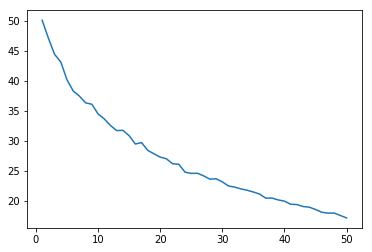

In [193]:
plt.plot(ks, k_cost)

##### From the results above, we can see that the cost keeps going down with increasing value of k, due to computation cost, we will select 40 as value of k and build a model of 40 clusters

In [211]:
neighborhoods_grouped_clustering = neighborhoods_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans_model = KMeans(n_clusters = 40, random_state=1).fit(neighborhoods_grouped_clustering)

neighborhoods_venues_sorted['Cluster'] = kmeans_model.labels_

neighborhoods_merged_ottawa = pd.merge(df_ott_neigh, neighborhoods_venues_sorted, on = 'Neighbourhood') #this is the output for Ottawa neighborhoods

neighborhoods_merged_toronto = pd.merge(df_toronto_neigh, neighborhoods_venues_sorted, on = 'Neighbourhood') #this is the output for Toronto neighborhoods 

In [209]:
neighborhoods_merged_ottawa.head()

,Neighbourhood,City,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
0,"ByWard Market, Ottawa",Ottawa,45.427917,-75.692601,Coffee Shop,Café,Restaurant,Hotel,Ice Cream Shop,Concert Hall,Mexican Restaurant,Art Gallery,French Restaurant,BBQ Joint,0
1,"Centretown, Ottawa",Ottawa,45.416340,-75.694286,Coffee Shop,Restaurant,Café,Hotel,Seafood Restaurant,Pub,Food Truck,Concert Hall,Pizza Place,Italian Restaurant,0
2,"Centretown West, Ottawa",Ottawa,45.416340,-75.694286,Coffee Shop,Restaurant,Café,Hotel,Seafood Restaurant,Pub,Food Truck,Concert Hall,Pizza Place,Italian Restaurant,0
3,"Downtown, Ottawa",Ottawa,45.433464,-75.669203,Pharmacy,Coffee Shop,Mexican Restaurant,Café,Grocery Store,Diner,Park,Middle Eastern Restaurant,Sandwich Place,Sushi Restaurant,16
4,"The Glebe, Ottawa",Ottawa,45.402221,-75.691623,Coffee Shop,Restaurant,Café,Pub,Sporting Goods Shop,Burrito Place,Bakery,Thai Restaurant,Gastropub,Breakfast Spot,0


In [212]:
neighborhoods_merged_toronto.head()

,Neighbourhood,City,Latitude,Longitude,Dist_to_downtown_km,map_label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
0,"Alexandra Park, Toronto",Toronto,43.650758,-79.404298,2,"Alexandra Park, Toronto, (Distance to Downtown...",Café,Bar,Coffee Shop,Pizza Place,Bakery,Cocktail Bar,Vegetarian / Vegan Restaurant,Mexican Restaurant,Sandwich Place,Dessert Shop,27
1,"The Annex, Toronto",Toronto,43.670338,-79.407117,3,"The Annex, Toronto, (Distance to Downtown: 3km)",Café,Restaurant,Italian Restaurant,Bakery,Korean Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Bookstore,Coffee Shop,27
2,"Baldwin Village, Toronto",Toronto,43.669818,-79.497172,10,"Baldwin Village, Toronto, (Distance to Downtow...",Pizza Place,Coffee Shop,Park,Sandwich Place,Beer Store,Indian Restaurant,Fried Chicken Joint,Bank,Bar,Grocery Store,16
3,"Cabbagetown, Toronto",Toronto,43.664473,-79.366986,1,"Cabbagetown, Toronto, (Distance to Downtown: 1km)",Coffee Shop,Restaurant,Grocery Store,Diner,Fast Food Restaurant,Café,Pharmacy,Thai Restaurant,Park,Beer Store,0
4,"CityPlace, Toronto",Toronto,43.639248,-79.396387,2,"CityPlace, Toronto, (Distance to Downtown: 2km)",Coffee Shop,Park,Italian Restaurant,Gym,Restaurant,Bar,Hotel,Café,Japanese Restaurant,Scenic Lookout,0


## Results & Disscusion <a name="results"></a>

##### Let's assume our friend who is relocating to Toronto is currently living in Barrhaven Ottawa

In [214]:
# Let's see the number of neighborhoods per cluster in Ottawa

neighborhoods_merged_ottawa.groupby('Cluster')['Neighbourhood'].count()

Cluster
0     18
1      1
2      3
3     14
4      2
5      3
6      1
7      1
8      1
9      1
10    61
11     4
12     1
13     1
14     2
15     1
16    22
17     1
18     1
19     1
20     2
21     2
22     1
23     2
24     1
25    49
26     1
27     8
28     1
29     1
30     1
31     4
32    15
33     1
34     1
35     1
36     3
37     1
38     3
39     1
Name: Neighbourhood, dtype: int64

In [222]:
print(("Barrhaven is a member cluster {}").format(neighborhoods_merged_ottawa[neighborhoods_merged_ottawa.Neighbourhood.str.lower().str.contains('barrhaven')].Cluster.values.astype(int)))

Barrhaven is a member cluster [25]


##### Let's check which neighborhoods in Toronto fall in the same cluster as Barrhaven in Ottawa

In [223]:
# Let's first see the number of neighborhoods per cluster in Toronto

neighborhoods_merged_toronto.groupby('Cluster')['Neighbourhood'].count()

Cluster
0     65
3     16
10    24
11     1
16    33
25     5
27    33
31     1
32    13
Name: Neighbourhood, dtype: int64

In [227]:
related_clusters_in_toronto = neighborhoods_merged_toronto[neighborhoods_merged_toronto.Cluster == 25].sort_values(['Dist_to_downtown_km'], ascending = True)

print(("These are the neighborhoods in Toronto that fall in the same cluster/group as Barrhaven in Ottawa, they are {} in number").format(neighborhoods_merged_toronto[neighborhoods_merged_toronto.Cluster == 25].map_label.count()))
print("They are sorted based on proximity to Downtown Toronto with the closest Neighbohoods to Downtown ranked highest")
print("---------------------------------------------------------------------------------------------------------------")

for i in related_clusters_in_toronto['map_label']:
    print(i)

These are the neighborhoods in Toronto that fall in the same cluster/group as Barrhaven in Ottawa, they are 5 in number
They are sorted based on proximity to Downtown Toronto with the closest Neighbohoods to Downtown ranked highest
---------------------------------------------------------------------------------------------------------------
Port Lands, Toronto, (Distance to Downtown: 3km)
Downsview, North York, Toronto, (Distance to Downtown: 12km)
Milliken, Scarborough, Toronto, (Distance to Downtown: 20km)
Brown's Corners (historical), Scarborough, Toronto, (Distance to Downtown: 21km)
Highland Creek, Scarborough, Toronto, (Distance to Downtown: 22km)


##### Let's examine the peculiarity of these 5 neighbourhoods in Toronto that fall in cluster 25

In [229]:
neighborhoods_merged_toronto[neighborhoods_merged_toronto.Cluster == 25].loc[5:]

,Neighbourhood,City,Latitude,Longitude,Dist_to_downtown_km,map_label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
36,"Port Lands, Toronto",Toronto,43.643065,-79.350601,3,"Port Lands, Toronto, (Distance to Downtown: 3km)",Boat or Ferry,Circus,Athletics & Sports,Beach,Pool,Music Venue,Nightclub,Theater,Supermarket,Harbor / Marina,25
128,"Downsview, North York, Toronto",Toronto,43.749299,-79.462248,12,"Downsview, North York, Toronto, (Distance to D...",Athletics & Sports,French Restaurant,Soccer Field,Gym / Fitness Center,Gym Pool,Fast Food Restaurant,Mediterranean Restaurant,Sandwich Place,Arts & Crafts Store,Basketball Court,25
153,"Brown's Corners (historical), Scarborough, Tor...",Toronto,43.812989,-79.243022,21,"Brown's Corners (historical), Scarborough, Tor...",Light Rail Station,Gym,Chinese Restaurant,Fast Food Restaurant,Sandwich Place,Automotive Shop,Vietnamese Restaurant,Train Station,Chocolate Shop,Indian Restaurant,25
161,"Highland Creek, Scarborough, Toronto",Toronto,43.790117,-79.173334,22,"Highland Creek, Scarborough, Toronto, (Distanc...",Breakfast Spot,Italian Restaurant,Burger Joint,Neighborhood,Flower Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,25
166,"Milliken, Scarborough, Toronto",Toronto,43.823217,-79.301523,20,"Milliken, Scarborough, Toronto, (Distance to D...",Chinese Restaurant,Japanese Restaurant,Bakery,Vegetarian / Vegan Restaurant,Asian Restaurant,Hong Kong Restaurant,Vietnamese Restaurant,Bubble Tea Shop,Noodle House,Bank,25


##### Key Take-Out:

* These neighbourhoods have a high concentration of sports & gym facilities (including swimming pools)
* There is also a variety of restaurants to pick from ranging from European, Asian and Middle East restaurants
* They also seem to have good transportation network considering the presence of train stations

##### Let's examine the clusters on Ottawa map

In [232]:
ott_address = 'Ottawa, ON, Canada'

geolocator = Nominatim(user_agent="canada_exp")
location = geolocator.geocode(ott_address)

ott_lat = location.latitude
ott_lon = location.longitude
ott_map = folium.Map(location=[ott_lat, ott_lon], zoom_start=10)

# add markers to map
# set color scheme for the clusters
k = 40
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods_merged_ottawa['Latitude'], neighborhoods_merged_ottawa['Longitude'], neighborhoods_merged_ottawa['Neighbourhood'], neighborhoods_merged_ottawa['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(ott_map)

ott_map

##### Let's examine the clusters on Toronto map

In [234]:
tor_address = 'Toronto, ON, Canada'

geolocator = Nominatim(user_agent="canada_exp")
location = geolocator.geocode(tor_address)

tor_lat = location.latitude
tor_lon = location.longitude
tor_map = folium.Map(location=[tor_lat, tor_lon], zoom_start=11)

# add markers to map
# set color scheme for the clusters
k = 40
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods_merged_toronto['Latitude'], neighborhoods_merged_toronto['Longitude'], neighborhoods_merged_toronto['map_label'], neighborhoods_merged_toronto['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(tor_map)

tor_map

## Conclusion <a name="conclusion"></a>

Through this model/analysis, we have been able to identify 5 neighborhoods within Toronto that are similar to Barrhaven in Ottawa, they are:
    
* Port Lands, Toronto, (Distance to Downtown: 3km)
* Downsview, North York, Toronto, (Distance to Downtown: 12km)
* Milliken, Scarborough, Toronto, (Distance to Downtown: 20km)
* Brown's Corners (historical), Scarborough, Toronto, (Distance to Downtown: 21km)
* Highland Creek, Scarborough, Toronto, (Distance to Downtown: 22km)

Future works are encouraged to improve on the variables used for this analysis like: *cost of accomodation in the neighborhoods*, *crime rate and security of the neighborhood*, *population per sq meter* etc. These can help to be more decisive in selection of a prefered location among the 5 within the list.

Thank you.